# What Happened to Crime Activity in Seattle?

This is part 2 of a project I initially started as a means of finding a place to live. I ended up moving before finishing the project, but the data was interesting enough to motivate me to finish it. While the primary overall goal of this project is to determine the quality of life throughout Seattle, I have a few secondary goals for this part of the project:
<ol>
    <li>Find out how criminal activity has changed with time in Seattle
    <li>Find out how much each Seattle neighborhood has experienced criminal activity
    <li>Consolidate this new information with past information on code violations to figure out the best neighborhoods
</ol>

In this part, I use data from my previous look at code violations in Seattle (in the time domain) as well as criminal activity data provided by [data.seattle.gov](data.seattle.gov). I will also use time series analysis methods I first encountered in [JTEST](TEst), and chloropleth creation code I encountered in [TEST](www.TEST.com)

## The Data

I use two data sets in part 2. The first contains 626557 logged [criminal cases](https://data.seattle.gov/Public-Safety/Seattle-Police-Department-Police-Report-Incident/7ais-f98f) around Seattle going back to 2007. The cases range from petty theft to homicide, and, if a case has more than one crime, it is logged multiple times. These are crimes that were called in by someone, responded to, and officially entered into the police records. Among other information, this set lists offense type, date, and location.
In addition to this, I use the code violation data from part 1 to figure out locational information for all the data sets.

## The Analysis

Using the same methods as in the previous part, I will use Pandas, Matplotlib, and Numpy for most all of the analysis. Using timestamps from the crime data, I can make timeseries' that make certain types of analysis easier.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('ggplot')

crimes = pd.read_csv('crimes.csv', index_col='Date Reported', parse_dates=True)
violation_counts = pd.read_csv('finalviolations.csv', sep=',', index_col=0, parse_dates=True)

Here are the headers for the 'crimes' dataset, and an example of what it looks like.

In [2]:
crimes.head(1)

,RMS CDW ID,General Offense Number,Offense Code,Offense Code Extension,Offense Type,Summary Offense Code,Summarized Offense Description,Occurred Date or Date Range Start,Occurred Date Range End,Hundred Block Location,District/Sector,Zone/Beat,Census Tract 2000,Longitude,Latitude,Location,Month,Year
Date Reported,,,,,,,,,,,,,,,,,,
2015-08-26 12:37:00,531946,2015298146,2404,4,VEH-THEFT-MTRCYCLE,2400,VEHICLE THEFT,08/23/2015 11:00:00 AM,08/23/2015 05:00:00 PM,52XX BLOCK OF 17 AV NE,U,U1,4400.3004,-122.309633,47.667477,"(47.667476948, -122.309633133)",8,2015


Now for some cleaning up. Turns out that there are a lot of entries that have only part of the information filled in, having either missing entries or have filler entries such as lat/longitude being set to zero. There is an outlier point from 1989 that is missing a significant chunk of information.

I'll strip away headers that I don't think are useful, e.g. we don't need 'location' if we have 'latitude' and 'longitude'. Really, the things I care about are the types of offenses and also where and when they happened.

In [3]:
crimes = crimes[['Summarized Offense Description','District/Sector', 'Zone/Beat', 'Latitude', 'Longitude']].dropna()
crimes = crimes[(crimes['Latitude'] != 0.0) & (crimes['Longitude'] != 0.0)]
crimes = crimes[crimes.index >= '2008-01-01']
len(crimes)

626554

So after some cleaning up, there are now 626554 fine points of data.

Here is a look at amounts of the different types of offenses listed in this dataset. The offense descriptions are sometimes in all caps or with the beginning letters capitalized, so I can combine these with Pandas to avoid having separate listings.

In [4]:
crimes['Summarized Offense Description'].str.capitalize().value_counts()

Car prowl                           113755
Other property                       76345
Burglary                             66231
Property damage                      47299
Vehicle theft                        45338
Fraud                                35032
Assault                              34662
Warrant arrest                       32415
Threats                              21689
Disturbance                          20597
Stolen property                      19915
Shoplifting                          19906
Narcotics                            15117
Robbery                              13640
Bike theft                           10183
Trespass                              8245
Burglary-secure parking-res           5629
Traffic                               4178
Weapon                                3267
Lost property                         3152
Prostitution                          3026
Dispute                               2862
Mail theft                            2823
Pickpocket 

Now, the two main things I want to do with this data are: 1) Figure out how crime has changed with time and 2) Figure out how crime counts are distributed throughout the city. However, there is a big spread in the kinds of offenses that are considered criminal activity. Something like fireworks does not bother me as much as homicide being nearby. 
My solution to this is to split up the criminal cases into "very bad to have nearby" and "not quite as bad to have nearby", which I call severe and mild. That is not to say I would want to live around the mild offenses, just that these severe offenses are very easy to point at and say "this makes a neighborhood unsafe."

In [5]:
severeoffense = np.array(['Assault', 'Threats', 'Narcotics', 'Weapon', 'Burglary', 'Homicide', 'Robbery', 'Car prowl', 'Pornography`'])
crimes['Severe'] = np.in1d(crimes['Summarized Offense Description'].str.capitalize(), severeoffense)

So here is a first look at how crime counts have changed in time since 2008 for both kinds of crimes

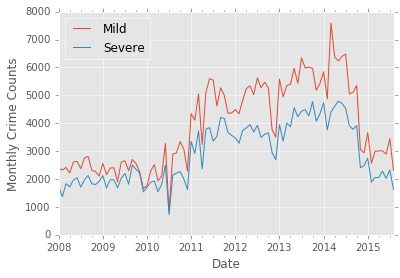

In [6]:
crime_counts = pd.DataFrame({'Severe': pd.Series(crimes[crimes['Severe'] == True].index.value_counts().resample('M', how='sum')),
                                    'Mild': pd.Series(crimes[crimes['Severe'] == False].index.value_counts().resample('M', how='sum'))})
crime_counts.plot()
plt.xlabel('Date')
plt.ylabel('Monthly Crime Counts')

There's a block of time between 2011 and 2015 where the number of all reported crimes, mild and severe, increases by something like a factor of 2. Sometime mid-late 2014, this steeply drops off and returns to normal.

In [7]:
crime_counts[:'2011-01-01'].describe()

,Mild,Severe
count,36.000000,36.000000
mean,2405.527778,1900.611111
std,465.047186,331.625113
min,821.000000,722.000000
25%,2249.500000,1715.250000
50%,2394.500000,1922.000000
75%,2636.750000,2125.250000
max,3344.000000,2501.000000


In [8]:
crime_counts['2011-01-01':'2015-01-01'].describe()

,Mild,Severe
count,48.000000,48.000000
mean,5157.666667,3814.479167
std,923.813519,611.654505
min,2932.000000,2360.000000
25%,4765.500000,3521.250000
50%,5261.000000,3836.500000
75%,5603.250000,4238.000000
max,7592.000000,4790.000000


In fact, the mean number of reported crimes between 2011-2015 is very close to 2x higher than between 2008-2011. The minimum reported each month is much higher and the spread is 2x larger between 2011-2015. What is this heightening of reported criminal activity?

Using methods from part 1, I can isolate contributions from seasonal variations:

In [9]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    diff = date - pd.datetime(2000, 12, 21)
    day = diff.total_seconds() / 24. / 3600
    day %= 365.25
    m = 1. - np.tan(np.radians(latitude)) * np.tan(np.radians(axis) * np.cos(day * np.pi / 182.625))
    m = max(0, min(m, 2))
    return 24. * np.degrees(np.arccos(1 - m)) / 180.

In [10]:
crime_counts['Daylight Hours'] = pd.Series(crime_counts.index.map(hours_of_daylight), index=crime_counts.index)

In [11]:
from sklearn.linear_model import LinearRegression

X = crime_counts['Daylight Hours'][:,np.newaxis]
y1 = crime_counts['Severe'][:,np.newaxis]
y2 = crime_counts['Mild'][:,np.newaxis]
fit1 = LinearRegression().fit(X,y1)
fit2 = LinearRegression().fit(X,y2)

crime_counts['Trend1S'] = fit1.predict(X)
crime_counts['Trend1M'] = fit2.predict(X)
crime_counts['Detrended1S'] = crime_counts['Severe'] - crime_counts['Trend1S'] + crime_counts['Trend1S'].mean()
crime_counts['Detrended1M'] = crime_counts['Mild'] - crime_counts['Trend1M'] + crime_counts['Trend1M'].mean()

So here is what it looks like without seasonal variations. It does not really make much difference!

Detrended1S    1062.031108
Severe         1064.409928
Detrended1M    1513.552950
Mild           1526.384127
dtype: float64

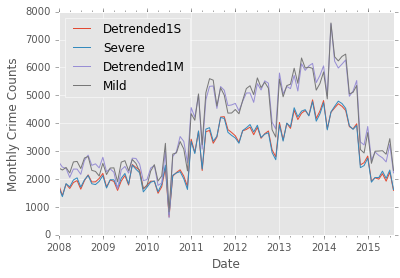

In [12]:
crime_counts[['Detrended1S','Severe','Detrended1M','Mild']].plot()
plt.xlabel('Date')
plt.ylabel('Monthly Crime Counts')
crime_counts[['Detrended1S','Severe','Detrended1M','Mild']].std()

The truth is that, even after a lot of searching, I cannot actually find anything that properly explains why this big jump in reported cases happens. I can take a look at the top 5 kinds of offenses to see if something is skewing the results...

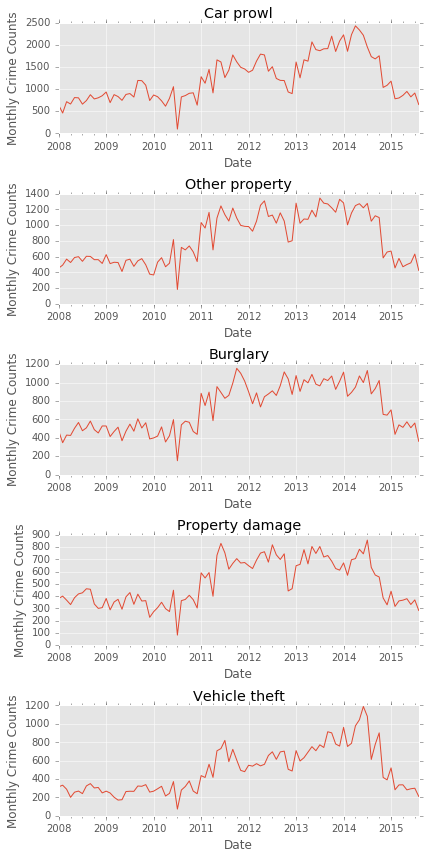

In [13]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(6,12))

descriptions = crimes['Summarized Offense Description'].str.capitalize()
offenses = [descriptions.value_counts().index[i] for i in range(5)]

for i in range(5):
    descriptions[descriptions == offenses[i]].index.value_counts().resample('M', how='sum').plot(ax=axes[i])
    axes[i].set_title(str(offenses[i]))
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Monthly Crime Counts')
fig.tight_layout()

But they all have roughly the same anomaly! I can split it up by district (which was a pain to figure out each sector's designation):

In [14]:
dist = crimes['District/Sector']
distN = crimes[(dist == 'B') | (dist == 'N') | (dist == 'L') | (dist == 'J') | (dist == 'U')]
distS = crimes[(dist == 'O') | (dist == 'R') | (dist == 'S')]
distE = crimes[(dist == 'E') | (dist == 'C') | (dist == 'G')]
distW = crimes[(dist == 'Q') | (dist == 'D') | (dist == 'M') | (dist == 'K')]
distSW = crimes[(dist == 'W') | (dist == 'F')]

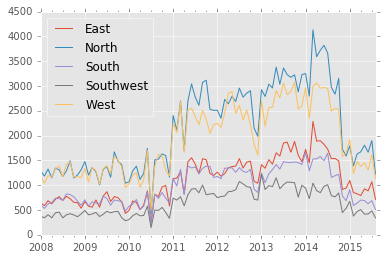

In [15]:
dist_tot = pd.DataFrame({'North': distN.index.value_counts(), 'South': distS.index.value_counts(),
                         'East': distE.index.value_counts(), 'West': distW.index.value_counts(),
                         'Southwest': distSW.index.value_counts()})

dist_tot.resample('M', how='sum').plot()

And again, this does not really show anything past this being a city-wide jump in reporting of all kinds of crimes. This could be some kind of internal policy change on general policing and reporting, or it could be a change in how much data was actually put online. Frankly, I have no idea!

Next, I look at the locational information contained in both the crime and code violation data sets through the use of neat maps called choropleths. They give a visual representation of how the counts are distributed throughout each neighborhood of Seattle. Big thanks to Tyler Hartley for coding exactly what I was looking for (http://beneathdata.com/how-to/visualizing-my-location-history/). His writeups are great, I highly recommend checking his stuff out. Most of the code from here on out is taken and slightly modified from the above link.

First I read in the old code violations data and use only data from 2008-present to match the crime data.

In [16]:
violations = pd.read_csv('violations.csv', header=0, index_col='Date Case Created', parse_dates=True)
violations = violations[:'2008-01-01']

The code for creating the choropleth map is too long to have here, but it can be found in its original form on [Tyler Hartey's website](http://beneathdata.com/how-to/visualizing-my-location-history/), or in its module form on my [Github](https://gist.github.com/RaySSharma/5077ad8e2d8ea442b085923d5b2133d4). I split up the crime data between mild and severe crimes.

In [17]:
import choropleth as ch
severe = crimes['Severe'] == True
mild = crimes['Severe'] == False

I want 4 choropleth maps: one for all code violations, one for all crime reports, then two for mild&severe crimes only. All the module needs is the shapefile, input data, desired figure size, and labels for titles and output image!

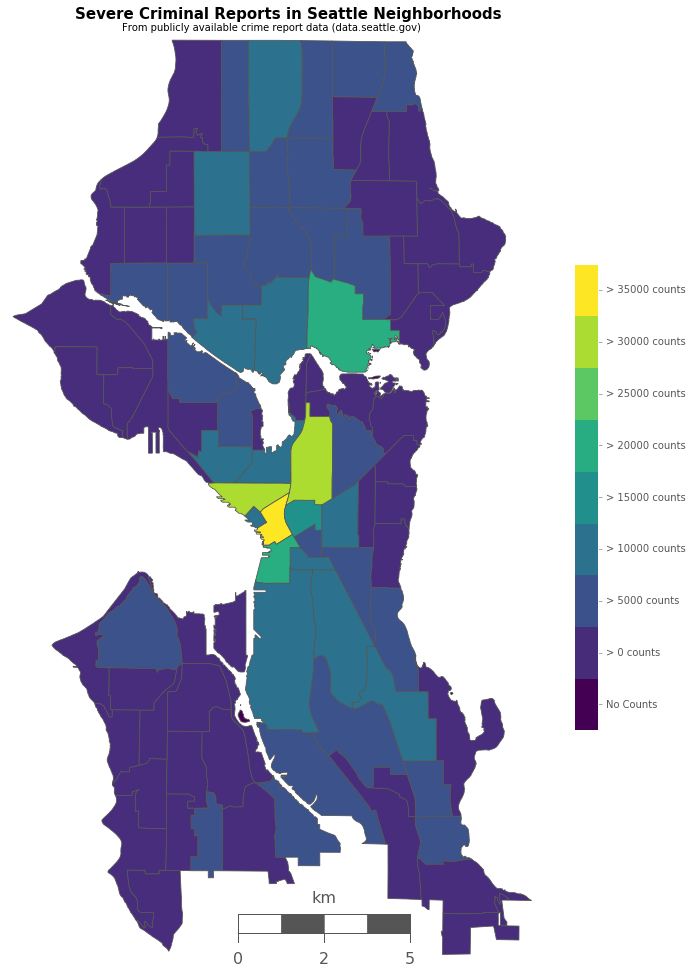

In [21]:
shapefilename = 'Neighborhoods/WGS84/Neighborhoods'
figwidth = 14
title = 'From publicly available crime report data (data.seattle.gov)'
suptitle = 'All Criminal Reports in Seattle Neighborhoods (2008-2015)'
savename = 'allcrime.png'
ch.choropleth(shapefilename, crimes['Latitude'], crimes['Longitude'], title, suptitle, savename, figwidth)

In [22]:
shapefilename = 'Neighborhoods/WGS84/Neighborhoods'
figwidth = 14
title = 'From publicly available code violation inspection data (data.seattle.gov)'
suptitle = 'Public Coding Violations in Seattle Neighborhoods'
savename = 'allviolations.png'
ch.choropleth(shapefilename, violations['Latitude'], violations['Longitude'], title, suptitle, savename, figwidth)

AttributeError: module 'choropleth' has no attribute 'choropleth'

In [ ]:
shapefilename = 'Neighborhoods/WGS84/Neighborhoods'
figwidth = 14
title = 'From publicly available crime report data (data.seattle.gov)'
suptitle = 'Severe Criminal Reports in Seattle Neighborhoods (2008-2015)'
savename = 'severecrime.png'
ch.choropleth(shapefilename, crimes[severe]['Latitude'], crimes[severe]['Longitude'], title, suptitle, savename, figwidth)

In [ ]:
shapefilename = 'Neighborhoods/WGS84/Neighborhoods'
figwidth = 14
title = 'From publicly available crime report data (data.seattle.gov)'
suptitle = 'Mild Criminal Reports in Seattle Neighborhoods (2008-2015)'
savename = 'mildcrime.png'
ch.choropleth(shapefilename, crimes[mild]['Latitude'], crimes[mild]['Longitude'], title, suptitle, savename, figwidth)